In [3]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn import tree
from random import uniform
import category_encoders as ce
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from yellowbrick.target import class_balance, ClassBalance, FeatureCorrelation
from yellowbrick.features import Rank2D, rank1d, rank2d
from yellowbrick.model_selection import FeatureImportances, ValidationCurve
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, ClassPredictionError

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load data

In [4]:
# Read data
training_data = pd.read_csv('training_data.csv', low_memory=False)
test_data = pd.read_csv('test_data.csv', low_memory=False)

In [5]:
y_train = training_data["If_paid"]
X_train = training_data.drop(columns="If_paid")
y_test = test_data["If_paid"]
X_test = test_data.drop(columns="If_paid")

In [6]:
training_data.head()

,sub_grade,delinq_2yrs,pub_rec,loan_amnt,avg_cur_bal,total_acc,mths_since_recent_bc,mo_sin_rcnt_tl,num_accts_ever_120_pd,mo_sin_rcnt_rev_tl_op,total_bal_ex_mort,dti,total_bc_limit,num_actv_rev_tl,total_il_high_credit_limit,num_bc_sats,num_bc_tl,num_rev_accts,num_op_rev_tl,mths_since_recent_inq,initial_list_status_f,percent_bc_gt_75,annual_inc,total_rev_hi_lim,If_paid
0,6,0.0,1.0,25000,2727.0,27.0,6.0,6.0,1.0,6.0,43626.0,18.64,22400.0,8.0,68124.0,5.0,9.0,17.0,12.0,6.0,0,0.0,150000.0,31900.0,1
1,2,0.0,0.0,12600,4915.0,12.0,42.0,7.0,0.0,7.0,24575.0,7.61,42700.0,4.0,0.0,4.0,8.0,9.0,5.0,5.0,1,25.0,90376.0,46700.0,0
2,5,1.0,0.0,10000,14690.0,22.0,31.0,2.0,0.0,2.0,22955.0,17.94,12200.0,5.0,25110.0,4.0,4.0,12.0,9.0,2.0,1,50.0,60000.0,19600.0,1
3,6,0.0,0.0,3975,4019.0,16.0,5.0,5.0,0.0,5.0,36172.0,31.43,12100.0,4.0,42088.0,3.0,8.0,12.0,7.0,5.0,1,0.0,37000.0,23800.0,1
4,28,1.0,0.0,11200,4073.0,56.0,4.0,4.0,0.0,4.0,86244.0,16.22,47100.0,9.0,65441.0,10.0,15.0,22.0,16.0,3.0,0,10.0,80000.0,60400.0,1


In [7]:
print(training_data.shape)
print(test_data.shape)

(80488, 25)
(17577, 25)


In [8]:
training_data.columns

Index(['sub_grade', 'delinq_2yrs', 'pub_rec', 'loan_amnt', 'avg_cur_bal',
       'total_acc', 'mths_since_recent_bc', 'mo_sin_rcnt_tl',
       'num_accts_ever_120_pd', 'mo_sin_rcnt_rev_tl_op', 'total_bal_ex_mort',
       'dti', 'total_bc_limit', 'num_actv_rev_tl',
       'total_il_high_credit_limit', 'num_bc_sats', 'num_bc_tl',
       'num_rev_accts', 'num_op_rev_tl', 'mths_since_recent_inq',
       'initial_list_status_f', 'percent_bc_gt_75', 'annual_inc',
       'total_rev_hi_lim', 'If_paid'],
      dtype='object')

### Class distribution

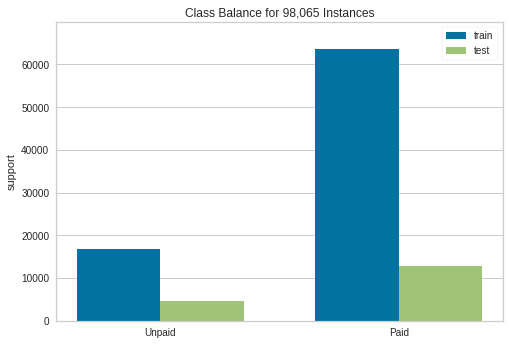

<AxesSubplot:title={'center':'Class Balance for 98,065 Instances'}, ylabel='support'>

In [9]:
vis = ClassBalance(labels=['Unpaid', 'Paid'])
vis.fit(training_data["If_paid"], test_data["If_paid"])
vis.show()

In [10]:
# percentage class distribution
training_data.groupby('If_paid').count()['loan_amnt']/len(training_data)

If_paid
0    0.209572
1    0.790428
Name: loan_amnt, dtype: float64

In [11]:
X_train.columns

Index(['sub_grade', 'delinq_2yrs', 'pub_rec', 'loan_amnt', 'avg_cur_bal',
       'total_acc', 'mths_since_recent_bc', 'mo_sin_rcnt_tl',
       'num_accts_ever_120_pd', 'mo_sin_rcnt_rev_tl_op', 'total_bal_ex_mort',
       'dti', 'total_bc_limit', 'num_actv_rev_tl',
       'total_il_high_credit_limit', 'num_bc_sats', 'num_bc_tl',
       'num_rev_accts', 'num_op_rev_tl', 'mths_since_recent_inq',
       'initial_list_status_f', 'percent_bc_gt_75', 'annual_inc',
       'total_rev_hi_lim'],
      dtype='object')

### Pearson variables correlationn

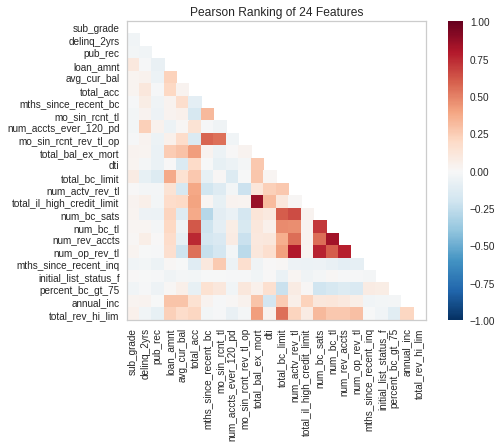

<AxesSubplot:title={'center':'Pearson Ranking of 24 Features'}>

In [12]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

visualizer.fit(X_train, y_train)           # Fit the data to the visualizer
visualizer.transform(X_train)        # Transform the data
visualizer.show()   

In [13]:
cols_to_drop = ["num_rev_accts", "total_il_high_credit_limit", "num_op_rev_tl", "num_bc_sats", "num_bc_tl"]
X_train = X_train.drop(columns=cols_to_drop)

In [14]:
X_test= X_test.drop(columns=cols_to_drop)

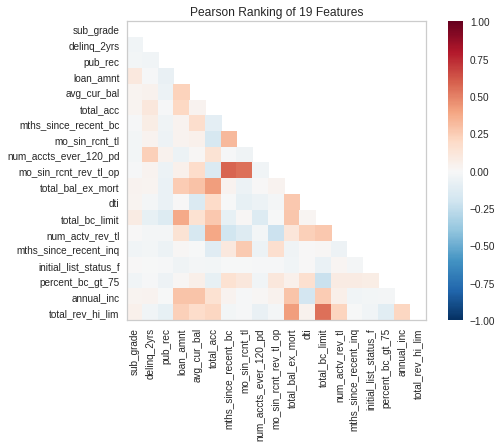

<AxesSubplot:title={'center':'Pearson Ranking of 19 Features'}>

In [15]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

visualizer.fit(X_train, y_train)           # Fit the data to the visualizer
visualizer.transform(X_train)        # Transform the data
visualizer.show()   

## Pearson correlation between target and features

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


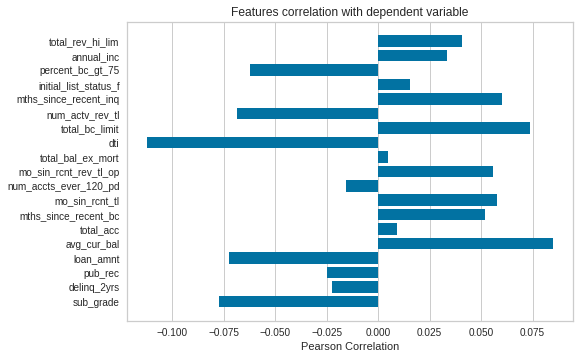

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [16]:
visualizer = FeatureCorrelation(labels=X_train.columns)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()    

## Feature importance

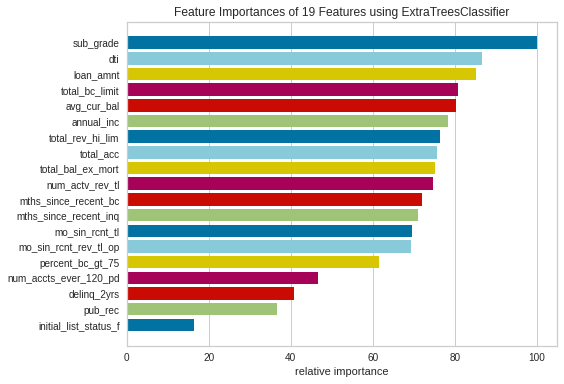

<AxesSubplot:title={'center':'Feature Importances of 19 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [17]:
model = ExtraTreesClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(X_train, y_train)
viz.show()

## Models

### XGBoost

In [18]:
xgb_cl=xgb.XGBClassifier(random_state=0, nthread=4)
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

#### Tuned parameters

In [43]:
# tune parameters
distributions = {
    "learning_rate"    : [0.05, 0.1, 0.4, 0.8],
    "n_estimators": [100,300,500],
    "max_depth"        :  [3,5,7],
    "min_child_weight" : [1,3,5],
    "subsample": [0.5,0.8, 1],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.4, 1, 5],
    "colsample_bytree" : [ 0.5 , 0.7,1]}

xgb_grid = RandomizedSearchCV(xgb_cl, distributions, random_state=0,  scoring='roc_auc')
search1 = xgb_grid.fit(X_train, y_train)
parameters_random_search = search1.best_params_
parameters_random_search

{'subsample': 0.5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 5,
 'colsample_bytree': 0.5}

In [22]:
param = {'subsample': 0.5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 5,
 'colsample_bytree': 0.5}
#parameters_random_search["random_state"]=0
#xgb_grid=xgb.XGBClassifier(**parameters_random_search)
xgb_grid=xgb.XGBClassifier(**param)
xgb_grid.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
xgb_grid.score(X_test, y_test)

0.7373271889400922

## learning rate - validation curve (that takes a while...)

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


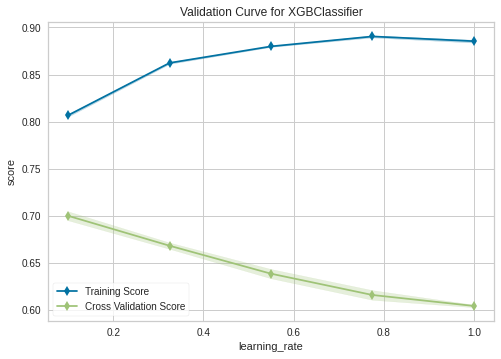

<AxesSubplot:title={'center':'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>

In [35]:
viz = ValidationCurve(
    xgb_grid,
    param_name="learning_rate",
    param_range=np.linspace(0.1, 1,5),
    cv=5, scoring="roc_auc",
    n_jobs=4
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

## Evaluation

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/angelika/.local/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


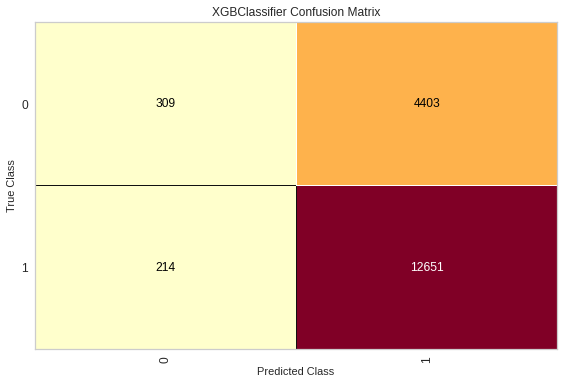

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [24]:
cm = ConfusionMatrix(xgb_grid, classes=[0,1])
#cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

## ROC curve

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


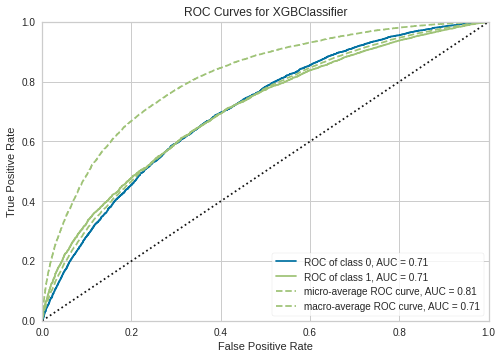

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
visualizer = ROCAUC(xgb_grid, 
                    classes=[0,1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()   

## Prediction error

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/angelika/.local/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


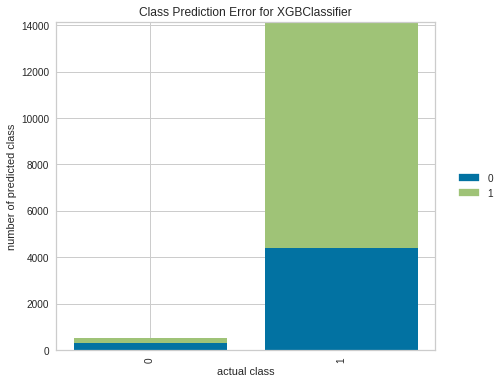

<AxesSubplot:title={'center':'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [29]:
visualizer = ClassPredictionError(
    xgb_grid, 
    classes=[0,1]
)

# Fit the training data to the visualizer
#visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()